# IE4483 AI and Data Mining Mini Project

In [ ]:
import pandas as pd
import numpy as np
import cv2
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive/')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers, optimizers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Resizing, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import itertools
import os
import shutil
import random as rn

import glob
import matplotlib.pyplot as plt
import seaborn as sb
sb.set() # set the default Seaborn style for graphics

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

# Activate inline plotting in notebook
py.init_notebook_mode(connected = False)

Output hidden; open in https://colab.research.google.com to view.

## Dogs vs Cats

In [ ]:
# Checking the number of images in the train, test, and validation directories

print(len(os.listdir('/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets')))
print(len(os.listdir('/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets/test')))
print(len(os.listdir('/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets/train/cat')))
print(len(os.listdir('/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets/train/dog')))
print(len(os.listdir('/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets/valid/cat')))
print(len(os.listdir('/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets/valid/dog')))

3
500
1000
1000
250
250


In [ ]:
# Ensuring reproducibility for non-deterministic algorithms
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

train_path = '/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets/train'
valid_path = '/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets/valid'
test_path = '/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/datasets'

In [ ]:
# 100 train batches
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory = train_path, target_size = (224, 224), classes = ['cat', 'dog'], batch_size = 20)

# 20 validation batches
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory = valid_path, target_size = (224, 224), classes = ['cat', 'dog'], batch_size = 25)

test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
.flow_from_directory(directory = test_path, target_size = (224, 224), classes=['test'], shuffle = False)

Found 2000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 1 classes.


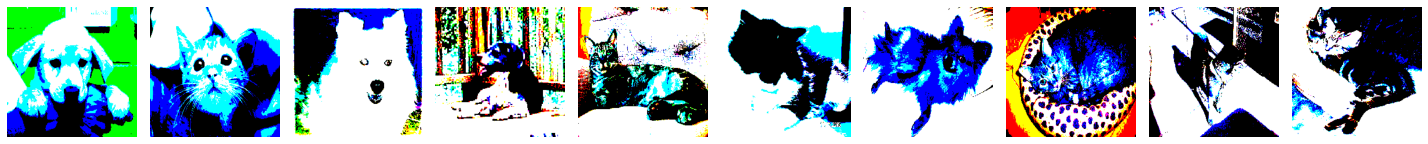

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
# cat: 1.0.
# dog: 0.1.
imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [ ]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
mini_model = Sequential()

# Iterating over each of the layers in vgg16_model, except for the last layer, and adding each layer to the new Sequential model
for layer in vgg16_model.layers[:-1]:
    mini_model.add(layer)

# Freezing the weights and other trainable parameters in each layer so that they will not be trained or updated when we later pass in our images of cats and dogs
for layer in mini_model.layers:
    layer.trainable = False

# Adding our new output layer, consisting of only 2 nodes that correspond to cat and dog. This output layer will be the only trainable layer in the model.
mini_model.add(Dense(units=2, activation='softmax'))
mini_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
# Using the Adam optimizer with a learning rate of 0.0001, categorical_crossentropy as loss, and accuracy as our metric
mini_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
mini_model.fit(x = train_batches,
          steps_per_epoch = len(train_batches),
          validation_data = valid_batches,
          validation_steps = len(valid_batches),
          epochs = 2, verbose = 2)

Epoch 1/2
100/100 - 1368s - loss: 0.3409 - accuracy: 0.8560 - val_loss: 0.1051 - val_accuracy: 0.9660 - 1368s/epoch - 14s/step
Epoch 2/2
100/100 - 1357s - loss: 0.0978 - accuracy: 0.9610 - val_loss: 0.0715 - val_accuracy: 0.9720 - 1357s/epoch - 14s/step


In [ ]:
test_predictions = mini_model.predict(x = test_batches, verbose=0)
test_pred = np.argmax(test_predictions, axis=-1)
test_files = test_batches.filenames
test_pred

array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,

In [ ]:
test_results = pd.DataFrame()

test_results['Image ID'] = test_files
test_results['Label'] = test_pred
test_results['Label'] = test_results['Label'].astype(int)

test_results['Image ID'] = test_results['Image ID'].apply(lambda x: x.strip()[5:len(x)-4]).astype(int)
test_results = test_results.sort_values(by = ['Image ID']).reset_index(drop = True)

test_results['Prediction'] = test_results['Label'].apply(lambda x: 'Dog' if x==1 else 'Cat')
test_results.to_csv('/content/drive/My Drive/IE4483 AI and Data Mining Mini Project/Mini Project Submission.csv', index = False)
test_results

,Image ID,Label,Prediction
0,1,1,Dog
1,2,1,Dog
2,3,1,Dog
3,4,1,Dog
4,5,0,Cat
...,...,...,...
495,496,1,Dog
496,497,0,Cat
497,498,1,Dog
498,499,1,Dog


## CIFAR-10 Dataset

In [ ]:
# Ensuring reproducibility for non-deterministic algorithms
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(37)
rn.seed(1254)
tf.random.set_seed(89)

In [ ]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()

# Preprocessing the train and test images before passing them into the VGG-16 model
X_train = tf.keras.applications.vgg16.preprocess_input(X_train)
X_test = tf.keras.applications.vgg16.preprocess_input(X_test)
print()

print(X_train.shape)
print(X_test.shape)
print()

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

print(y_train.shape)
print(y_train[:5])
print()

print(y_test.shape)
print(y_test[:5])

170498071/170498071 [==============================] - 3s 0us/step

(50000, 32, 32, 3)
(10000, 32, 32, 3)

(50000,)
[6 9 9 4 1]

(10000,)
[3 8 8 0 6]


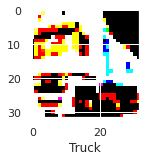

In [ ]:
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]

def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

plot_sample(X_train, y_train, 1)

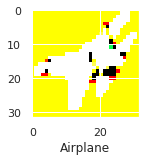

In [ ]:
plot_sample(X_test, y_test, 10)

In [ ]:
vgg16_cifar = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))
cifar_model = Sequential()

# Iterating over each of the layers in vgg16_cifar, and adding each layer to the new Sequential model
for layer in vgg16_cifar.layers:
    cifar_model.add(layer)

# Freezing the weights and other trainable parameters in each layer so that they will not be trained or updated
for layer in cifar_model.layers:
    layer.trainable = False

# Adding 2 fully connected layers to the neural network
cifar_model.add(Flatten())
cifar_model.add(Dense(units = 256, activation = LeakyReLU(alpha = 0.01)))
cifar_model.add(Dense(units = 256, activation = 'relu'))

# Adding our new output layer, consisting of 10 nodes that correspond to 10 image classes
cifar_model.add(Dense(units=10, activation='softmax'))
cifar_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                         

In [ ]:
# Using the Adam optimizer with a learning rate of 0.001, sparse_categorical_crossentropy as loss, and accuracy as our metric
cifar_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training the model
cifar_model.fit(x = X_train, y = y_train, epochs = 8, verbose = 2)

Epoch 1/8
1563/1563 - 492s - loss: 1.3889 - accuracy: 0.5757 - 492s/epoch - 315ms/step
Epoch 2/8
1563/1563 - 491s - loss: 0.9496 - accuracy: 0.6714 - 491s/epoch - 314ms/step
Epoch 3/8
1563/1563 - 493s - loss: 0.8595 - accuracy: 0.6991 - 493s/epoch - 315ms/step
Epoch 4/8
1563/1563 - 499s - loss: 0.7870 - accuracy: 0.7253 - 499s/epoch - 319ms/step
Epoch 5/8
1563/1563 - 501s - loss: 0.7116 - accuracy: 0.7464 - 501s/epoch - 320ms/step
Epoch 6/8
1563/1563 - 513s - loss: 0.6285 - accuracy: 0.7759 - 513s/epoch - 328ms/step
Epoch 7/8
1563/1563 - 490s - loss: 0.5672 - accuracy: 0.7970 - 490s/epoch - 314ms/step
Epoch 8/8
1563/1563 - 492s - loss: 0.4984 - accuracy: 0.8214 - 492s/epoch - 315ms/step


In [ ]:
# Evaluating the model on the test data
cifar_model.evaluate(X_test, y_test)

313/313 [==============================] - 104s 330ms/step - loss: 1.3312 - accuracy: 0.6447


[1.33121919631958, 0.6446999907493591]

## References:

__[TensorFlow: Python Deep Learning Neural Network API](https://deeplizard.com/learn/video/RznKVRTFkBY)__

__[CodeBasics: CIFAR-10 Image Classification](https://github.com/codebasics/deep-learning-keras-tf-tutorial/blob/master/16_cnn_cifar10_small_image_classification/cnn_cifar10_dataset.ipynb)__

***

# End of Code
# Thank you!